In [40]:
from utils.torch_model import CustomNet

model = CustomNet()
model.load_state_dict(torch.load('./models/custom_net_yolo_v1.pth'))
model.eval()

CustomNet(
  (conv1d1): ModuleList(
    (0-3): 4 x Conv1d(2, 8, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (conv1d2): ModuleList(
    (0-3): 4 x Conv1d(8, 1, kernel_size=(2,), stride=(1,))
  )
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=48, bias=True)
  (dropout1): Dropout(p=0, inplace=False)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=48, out_features=32, bias=True)
  (dropout2): Dropout(p=0, inplace=False)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=24, bias=True)
)

In [86]:
import json
from scripts.parsers import parse_sequences as parse_sequence_info
from utils.torch_train_utils import get_train_valid_test_set, MoCapInputDataset
from torch.utils.data import DataLoader

file_path = 'gait3d\\ListOfSequences.txt'
sequences = parse_sequence_info(file_path)

selected_names_file = "./datasets/yolo/selected_joint_names.json"
input_data_file = "./datasets/yolo/dataset_v2.json"
output_data_file = "./datasets/mocap/dataset_v2.json"
triang_data_file = "./datasets/yolo/triangulation_v2.json"

with open(input_data_file, 'r') as file:
    raw_input = json.load(file)

with open(output_data_file, 'r') as file:
    raw_output = json.load(file)

with open(triang_data_file, 'r') as file:
    triangulation_data = json.load(file)

with open(selected_names_file, 'r') as file:
    selected_names = json.load(file)

with open("./datasets/train_test_split.json", "r") as f:
    train_test_split = json.load(f)

test_seq_set = train_test_split["test"]
print(f"test sequences unique: {test_seq_set[:6]} | test sequences clothing change: {test_seq_set[6:]} ")

BATCH_SIZE = 64

test_ds_uniqe = MoCapInputDataset(test_seq_set[:6], sequences, selected_names, raw_input, raw_output)
test_loader_uniqe = DataLoader(test_ds_uniqe, batch_size=BATCH_SIZE, shuffle=False)

test_ds_cloth_change = MoCapInputDataset(test_seq_set[6:], sequences, selected_names, raw_input, raw_output)
test_loader_cloth_change = DataLoader(test_ds_cloth_change, batch_size=BATCH_SIZE, shuffle=False)

test sequences unique: ['p16s1', 'p16s3', 'p13s1', 'p13s3', 'p4s1', 'p4s3'] | test sequences clothing change: ['p29s5', 'p29s7', 'p26s5', 'p26s7'] 


In [87]:
import torch

def compute_pa_mpjpe(predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Compute Procrustes Aligned MPJPE (PA-MPJPE).
    """
    B, J, _ = predicted.shape
    aligned_preds = []

    for i in range(B):
        pred = predicted[i]
        gt = target[i]

        # center both poses
        pred_mean = pred.mean(dim=0, keepdim=True)
        gt_mean = gt.mean(dim=0, keepdim=True)
        pred_centered = pred - pred_mean
        gt_centered = gt - gt_mean

        # SVD for optimal rotation
        H = pred_centered.T @ gt_centered
        U, _, Vt = torch.linalg.svd(H)
        R = Vt.T @ U.T

        # reflection
        if torch.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T

        # scale
        var_pred = pred_centered.pow(2).sum()
        scale = torch.trace(R @ H) / var_pred

        # transform
        pred_aligned = scale * (pred_centered @ R)
        pred_aligned += gt_mean 

        aligned_preds.append(pred_aligned)

    aligned_preds = torch.stack(aligned_preds, dim=0)
    error = torch.norm(aligned_preds - target, dim=-1)
    return error.mean()


def compute_3dpck(predicted: torch.Tensor, target: torch.Tensor, threshold: float) -> torch.Tensor:
    """
    Compute 3D Percentage of Correct Keypoints (3DPCK) at a given threshold.
    """
    distances = torch.norm(predicted - target, dim=-1)
    correct = (distances < threshold).float()
    pck = correct.mean()
    return pck


def compute_mpjpe(predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Compute Mean Per Joint Position Error (MPJPE).
    """
    
    error = torch.norm(predicted - target, dim=-1)
    return error.mean()


In [125]:
def calculate_metrics(data_loader: DataLoader) -> tuple[float]:
    mpjpe_total = 0
    pa_mpjpe_total = 0
    pck200_total = 0
    pck150_total = 0
    pck100_total = 0
    count = 0
    
    for inputs, gt_joints in data_loader:
        with torch.no_grad():
            predicted = model(inputs)
            batch_size = predicted.shape[0]
            
        mpjpe_total += compute_mpjpe(predicted, gt_joints) * batch_size
        pa_mpjpe_total += compute_pa_mpjpe(predicted, gt_joints) * batch_size
        pck100_total += compute_3dpck(predicted, gt_joints, threshold=100.0) * batch_size
        pck150_total += compute_3dpck(predicted, gt_joints, threshold=150.0) * batch_size
        pck200_total += compute_3dpck(predicted, gt_joints, threshold=200.0) * batch_size
        count += batch_size
    
    mpjpe_avg = mpjpe_total / count
    pa_mpjpe_avg = pa_mpjpe_total / count
    pck100_avg = pck100_total / count
    pck150_avg = pck150_total / count
    pck200_avg = pck200_total / count

    return mpjpe_avg.item(), pa_mpjpe_avg.item(), pck100_avg.item(), pck150_avg.item(), pck200_avg.item()


In [163]:
combined_m_results = []

In [164]:
mpjpe_avg, pa_mpjpe_avg, pck100_avg, pck150_avg, pck200_avg = calculate_metrics(test_loader_uniqe)
combined_m_results.append([mpjpe_avg, pa_mpjpe_avg, pck100_avg*100, pck150_avg*100, pck200_avg*100])

print("_ _ _ Unique sequences _ _ _")
print(f"MPJPE: {mpjpe_avg:.2f} mm")
print(f"PA-MPJPE: {pa_mpjpe_avg:.2f} mm")
print(f"3DPCK@100mm: {pck100_avg * 100:.2f} %")
print(f"3DPCK@150mm: {pck150_avg * 100:.2f} %")
print(f"3DPCK@200mm: {pck200_avg * 100:.2f} %")

_ _ _ Unique sequences _ _ _
MPJPE: 272.80 mm
PA-MPJPE: 113.71 mm
3DPCK@100mm: 10.30 %
3DPCK@150mm: 32.02 %
3DPCK@200mm: 53.01 %


In [165]:
mpjpe_avg, pa_mpjpe_avg, pck100_avg, pck150_avg, pck200_avg = calculate_metrics(test_loader_cloth_change)
combined_m_results.append([mpjpe_avg, pa_mpjpe_avg, pck100_avg*100, pck150_avg*100, pck200_avg*100])

print("_ _ _ Clothing change sequences _ _ _")
print(f"MPJPE: {mpjpe_avg:.2f} mm")
print(f"PA-MPJPE: {pa_mpjpe_avg:.2f} mm")
print(f"3DPCK@100mm: {pck100_avg * 100:.2f} %")
print(f"3DPCK@150mm: {pck150_avg * 100:.2f} %")
print(f"3DPCK@200mm: {pck200_avg * 100:.2f} %")

_ _ _ Clothing change sequences _ _ _
MPJPE: 208.30 mm
PA-MPJPE: 78.76 mm
3DPCK@100mm: 6.25 %
3DPCK@150mm: 27.09 %
3DPCK@200mm: 54.01 %


In [166]:
import numpy as np

test_set_triangulation = {}
for seq_key in test_seq_set:
    seq_frames_triang = []
    for frame_data in triangulation_data[seq_key]:
        frame_prep_triang = {}
        for idx, name in selected_names.items():
            frame_prep_triang[name] = frame_data[int(idx)]

        seq_frames_triang.append(frame_prep_triang)

    test_set_triangulation[seq_key] = seq_frames_triang
    

In [167]:
import json

with open("./datasets/yolo/triangulation_select.json", "w") as f:
    json.dump(test_set_triangulation, f, indent=4)

In [168]:
def get_triang_frames_as_ternsor(test_seq_set):
    test_set_frames_triang = []
    for seq_key in test_seq_set:
        for frame_data in triangulation_data[seq_key]:
            frame_prep_triang = []
            for idx, name in selected_names.items():
                frame_prep_triang.append(np.array(frame_data[int(idx)])[[1, 2, 0]])
    
            test_set_frames_triang.append(frame_prep_triang)

    return np.array(test_set_frames_triang)
    

In [169]:
triang_ds = get_triang_frames_as_ternsor(test_seq_set)
triang_ds.shape

(1135, 8, 3)

In [170]:
test_ds = np.array(test_ds_uniqe.output_frames_data + test_ds_cloth_change.output_frames_data)
test_ds.shape

(1135, 8, 3)

In [171]:
mpjpe_avg = compute_mpjpe(torch.Tensor(test_ds), torch.Tensor(triang_ds)).item()
pa_mpjpe_avg = compute_pa_mpjpe(torch.Tensor(test_ds), torch.Tensor(triang_ds)).item()
pck100_avg = compute_3dpck(torch.Tensor(test_ds), torch.Tensor(triang_ds), threshold=100.0).item()
pck150_avg = compute_3dpck(torch.Tensor(test_ds), torch.Tensor(triang_ds), threshold=150.0).item()
pck200_avg = compute_3dpck(torch.Tensor(test_ds), torch.Tensor(triang_ds), threshold=200.0).item()

combined_m_results.append([mpjpe_avg, pa_mpjpe_avg, pck100_avg*100, pck150_avg*100, pck200_avg*100])

print("_ _ _ Triangulation _ _ _")
print(f"MPJPE: {mpjpe_avg:.2f} mm")
print(f"PA-MPJPE: {pa_mpjpe_avg:.2f} mm")
print(f"3DPCK@100mm: {pck100_avg * 100:.2f} %")
print(f"3DPCK@150mm: {pck150_avg * 100:.2f} %")
print(f"3DPCK@200mm: {pck200_avg * 100:.2f} %")

_ _ _ Triangulation _ _ _
MPJPE: 73.75 mm
PA-MPJPE: 48.28 mm
3DPCK@100mm: 78.41 %
3DPCK@150mm: 95.54 %
3DPCK@200mm: 99.43 %


In [197]:
combined_m_results = np.array(combined_m_results)

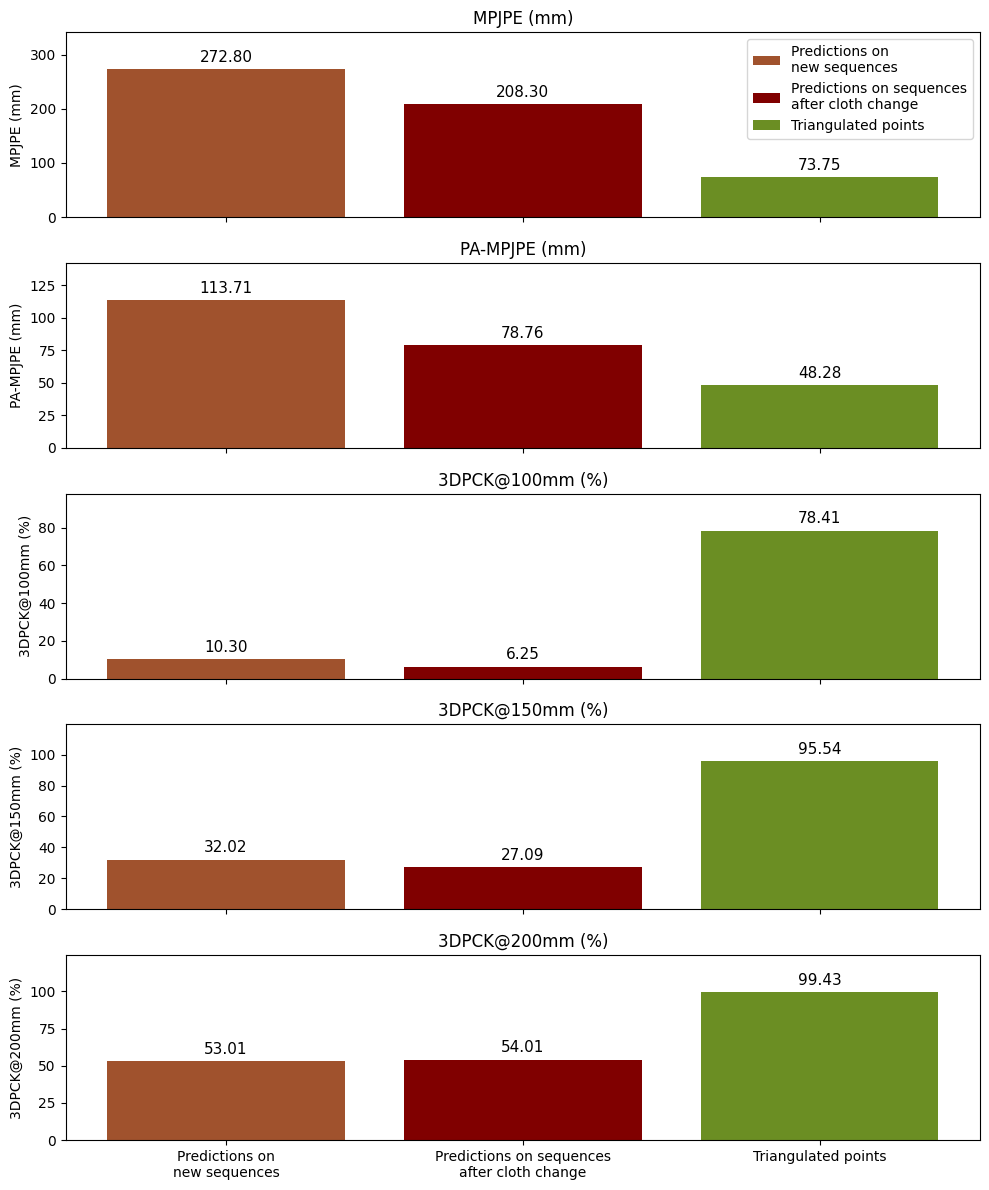

In [218]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Predictions on\nnew sequences', 'Predictions on sequences\nafter cloth change', 'Triangulated points']
title = ['MPJPE (mm)', 'PA-MPJPE (mm)', '3DPCK@100mm (%)', '3DPCK@150mm (%)', '3DPCK@200mm (%)']
colors = ['sienna', 'maroon', 'olivedrab']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 12), sharex=True)

for i in range(5):
    ax = axes[i]
    bars = ax.bar(categories, combined_m_results[:, i], color=colors)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.03 * combined_m_results[:, i].max(),
                f'{height:.2f}', ha='center', va='bottom', fontsize=11)

    ax.set_title(title[i])
    ax.set_ylabel(title[i])
    
    ax.set_ylim((0, 1.25 * combined_m_results[:, i].max()))

axes[0].legend(bars, categories, loc='upper right')

plt.tight_layout()
plt.savefig('./plots/3d_preds_evaluation.png')
plt.show()